# Machine Learning Engineer Nanodegree
## Capstone Project - Predicting Bitcoin Closing Prices
Benny Late	
January 17, 2018

## Data Preparation

In [1]:
# Import Libraries

import pandas as pd
from pandas import DataFrame
import numpy as np
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from random import randint
from datetime import datetime
from datetime import date
from itertools import product
import plotly.offline as py
import plotly.graph_objs as go
from matplotlib import pyplot as plt
py.init_notebook_mode(connected=True)
from pandas import Series
from statsmodels.tsa.arima_model import ARMAResults 
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers

data = pd.read_csv(r'C:\Users\Benny\Downloads\MLND\Capstone_Submission\BTC_Price_Data_2014_to_2018.csv')


Using TensorFlow backend.


In [2]:
# See data headers
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2,1417412100,300.0,300.0,300.0,300.0,0.01,3.0,300.0
3,1417412160,300.0,300.0,300.0,300.0,0.01,3.0,300.0
4,1417412220,300.0,300.0,300.0,300.0,0.01,3.0,300.0


In [4]:
# Group by date, create daily close price
data['date'] = pd.to_datetime(data['Timestamp'],unit='s').dt.date
group = data.groupby('date')
Daily_Close_Price = group['Close'].mean()
Daily_Close_Price.head()


date
2014-12-01    366.775068
2014-12-02    375.943056
2014-12-03    377.882701
2014-12-04    377.991743
2014-12-06    378.000000
Name: Close, dtype: float64

In [5]:
# Count days between dates for train/test sets 
# Training Set - December 2014 to December 2017
# Testing Set - February 2018 to June 2018

d0 = date(2014, 12, 1)
d1 = date(2018, 6, 27)
delta = d1 - d0
days_overall = delta.days + 1
print(days_overall)

d0 = date(2014, 12, 1)
d1 = date(2017, 12, 31)
delta = d1 - d0
days_training = delta.days + 1
print(days_training)

d0 = date(2018, 2, 1)
d1 = date(2018, 6, 27)
delta = d1 - d0
days_testing = delta.days + 1
print(days_testing)



1305
1127
147


## Create Training and Testing Sets

In [6]:
# Create Testing and Training Sets

df_train= Daily_Close_Price[:len(Daily_Close_Price)-days_testing]
df_test= Daily_Close_Price[len(Daily_Close_Price)-days_testing:]

print(len(df_train), len(df_test))

1124 147


## Exploratory Visualization

In [9]:
# For Data Exploratory Visualization Section, combine train and test sets into a single dataset

EV_data = [df_train, df_test]
EV_data = pd.concat(EV_data)

EV_data = EV_data.reset_index()
EV_data['date'] = pd.to_datetime(EV_data['date'])
EV_data = EV_data.set_index('date')


In [10]:
# For Visualization, create a chart showing trend and seasonality

s = sm.tsa.seasonal_decompose(EV_data.Close.values, freq=60)

trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Trend',
    line = dict(color = ('rgb(244, 146, 65)'), width = 4))
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Seasonal',
    line = dict(color = ('rgb(66, 244, 155)'), width = 2))
trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residual',
    line = dict(color = ('rgb(209, 244, 66)'), width = 2))
trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observed',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='seasonal_decomposition')


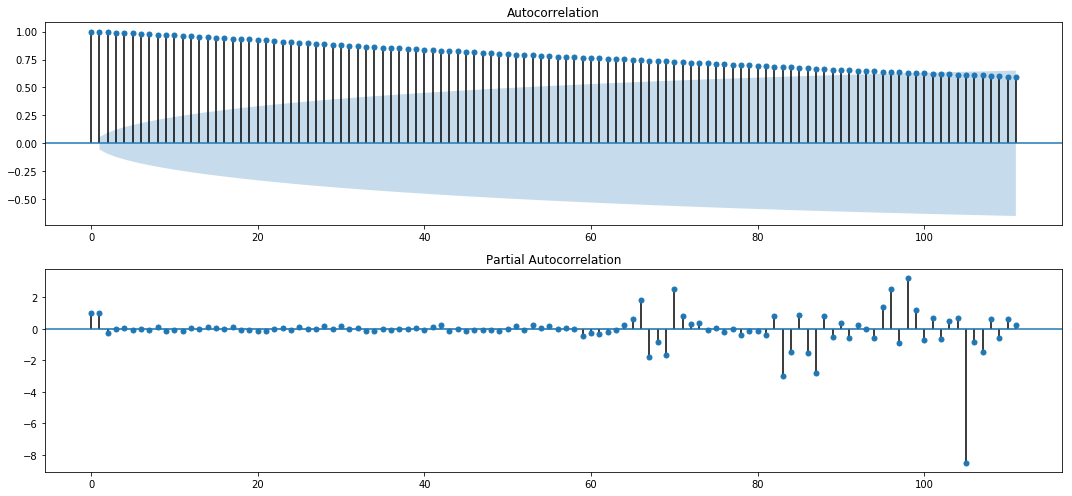

In [127]:
# For Visualization, show autocorrelation

plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(EV_data.Close.values.squeeze(), lags=111, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(EV_data.Close.values.squeeze(), lags=111, ax=ax)
plt.tight_layout()
plt.show()

In [9]:
#Confirm data is not stationary

from statsmodels.tsa.stattools import adfuller

ADF_Data = EV_data.iloc[:,0].values

result = adfuller(ADF_Data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.756426
p-value: 0.402299
Critical Values:
	5%: -2.864
	1%: -3.436
	10%: -2.568


## Data Preparation

In [11]:
# Create the "Look_Back" function

def create_lookback(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)


In [12]:
# Shape the Datasets

training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))


In [13]:
# Use MinMaxScaler to make sure scale is good for all my models

scaler = MinMaxScaler()
Norm_training_set = scaler.fit_transform(training_set)
Norm_test_set = scaler.transform(test_set)


In [14]:
# Add look_back to datasets and reshape so it will work for all models
look_back = 1
X_train, Y_train = create_lookback(Norm_training_set, look_back)
X_test, Y_test = create_lookback(Norm_test_set, look_back)

X_train = np.reshape(X_train, (len(X_train),X_train.shape[1],1))
X_test = np.reshape(X_test, (len(X_test),X_test.shape[1],1))


In [15]:
# Add look_back to datasets and reshape so it will work for all models
# Created second variable set for LSTM model

look_back = 1
X2_train, Y2_train = create_lookback(Norm_training_set, look_back)
X2_test, Y2_test = create_lookback(Norm_test_set, look_back)

X2_train = np.reshape(X2_train, (len(X2_train),X2_train.shape[1],1))
X2_test = np.reshape(X2_test, (len(X2_test),X2_test.shape[1],1))


In [16]:
# Add look_back to datasets and reshape so it will work for all models
# Created third variable set for GRU

look_back = 1
X3_train, Y3_train = create_lookback(Norm_training_set, look_back)
X3_test, Y3_test = create_lookback(Norm_test_set, look_back)

X3_train = np.reshape(X3_train, (len(X3_train),X3_train.shape[1],1))
X3_test = np.reshape(X3_test, (len(X3_test),X3_test.shape[1],1))


# Benchmark - ARIMA

In [13]:
# Evaluate ARIMA models for a given order (p,d,q)
warnings.filterwarnings("ignore") 

model = ARIMA(training_set, order=(8,1,3))
model_fit = model.fit(disp=0)
results = model_fit

# print summary of fit model
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1123
Model:                 ARIMA(8, 1, 3)   Log Likelihood               -7559.307
Method:                       css-mle   S.D. of innovations            202.694
Date:                Thu, 27 Dec 2018   AIC                          15144.615
Time:                        21:17:29   BIC                          15209.924
Sample:                             1   HQIC                         15169.297
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9456     10.773      0.738      0.461     -13.169      29.060
ar.L1.D.y      1.0678      0.067     16.016      0.000       0.937       1.198
ar.L2.D.y      0.1101      0.113      0.970      0.3

predicted=9798.172090, expected=9497.577813
predicted=9414.789602, expected=8547.647486
predicted=8422.008938, expected=8909.813083
predicted=9005.967221, expected=8736.636181
predicted=8810.654950, expected=7613.970403
predicted=7321.756135, expected=6807.273597
predicted=6665.458770, expected=7905.416028
predicted=7916.419538, expected=8203.784236
predicted=8027.093544, expected=8243.715354
predicted=7738.348262, expected=8649.373326
predicted=8689.392941, expected=8195.261715
predicted=7855.426320, expected=8619.035438
predicted=8651.414958, expected=8615.998597
predicted=8478.761029, expected=9019.139417
predicted=9189.891119, expected=9798.362437
predicted=10202.045235, expected=10017.390674
predicted=10221.364012, expected=10684.652396
predicted=11072.166498, expected=10729.090354
predicted=10840.414402, expected=10852.905000
predicted=10945.396662, expected=11493.998937
predicted=11677.676084, expected=10780.311528
predicted=10601.035622, expected=10267.798903
predicted=10203.24

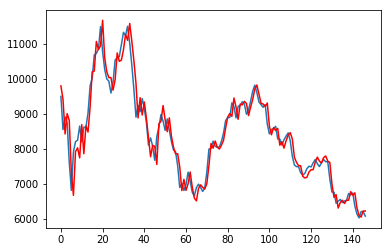

In [14]:
#Evaluate ARIMA forecasted data vs. test data
warnings.filterwarnings("ignore") 

#Predict
history = [x for x in training_set]
predictions = list()
for t in range(len(test_set)):
    model = ARIMA(history, order=(8,1,3))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_set[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

#MSE/RMSE
mse = mean_squared_error(test_set, predictions)
print('MSE: %f' % mse)

rmse = sqrt(mse)
print('RMSE: %f' % rmse)

#r2 Score
R2 = r2_score(test_set, predictions)
print('r2: %f' % R2)

#Plot Predictions
plt.plot(test_set)
plt.plot(predictions, color='red')
plt.show()

# RNN - 2 Layer LSTM

In [18]:
# Initialize sequential model, add 2 LSTM layers
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X2_train.shape[1], X2_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X2_train, Y2_train, epochs=100, batch_size=16, shuffle=False, 
                    validation_data=(X2_test, Y2_test), 
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

Train on 1123 samples, validate on 146 samples
Epoch 1/100
1123/1123 [==============================] - 3s 2ms/step - loss: 0.0033 - val_loss: 0.0366
Epoch 2/100
1123/1123 [==============================] - 1s 1ms/step - loss: 0.0402 - val_loss: 0.0232
Epoch 3/100
1123/1123 [==============================] - 1s 1ms/step - loss: 0.0087 - val_loss: 8.7362e-04
Epoch 4/100
1123/1123 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 5/100
1123/1123 [==============================] - 1s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/100
1123/1123 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 7/100
1123/1123 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 8/100
1123/1123 [==============================] - 1s 1ms/step - loss: 0.0032 - val_loss: 0.0076
Epoch 9/100
1123/1123 [==============================] - 1s 1ms/step - loss: 0.0048 - val_loss: 5.9705e-04
Epoch 10/100
1123/

In [19]:
#Training/Testing Loss visual

trace1 = go.Scatter(
    x = np.arange(0, len(history.history['loss']), 1),
    y = history.history['loss'],
    mode = 'lines',
    name = 'Train loss',
    line = dict(color=('rgb(66, 244, 155)'), width=2, dash='dash')
)
trace2 = go.Scatter(
    x = np.arange(0, len(history.history['val_loss']), 1),
    y = history.history['val_loss'],
    mode = 'lines',
    name = 'Test loss',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Train and Test Loss during training',
              xaxis = dict(title = 'Epoch number'), yaxis = dict(title = 'Loss'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='training_process')

In [20]:
# add one additional data point to align shapes of the predictions and true labels
#X2_test = np.append(X2_test, scaler.transform(EV_data.iloc[-1][0]))
#X2_test = np.reshape(X2_test, (len(X2_test), 1, 1))

# I could not get the X2_test append to work correctly.  Kept getting "Expected 2D, got scalar" error.
# So, I removed one of the predictions so RMSE would work.

# get predictions and then make some transformations to be able to calculate RMSE properly in USD
prediction = model.predict(X2_test)
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
Y2_test_inverse = scaler.inverse_transform(Y2_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y2_test2_inverse = np.array(Y2_test_inverse[:,0])
Y2_test2_inverse = Y2_test2_inverse[:-1]

In [21]:
#Updated visual with labels
trace1 = go.Scatter(
    x = np.arange(0, len(prediction2_inverse), 1),
    y = prediction2_inverse,
    mode = 'lines',
    name = 'Predicted labels',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)
trace2 = go.Scatter(
    x = np.arange(0, len(Y2_test2_inverse), 1),
    y = Y2_test2_inverse,
    mode = 'lines',
    name = 'True labels',
    line = dict(color=('rgb(66, 244, 155)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted',
             xaxis = dict(title = 'Day number'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')

In [22]:
RMSE = sqrt(mean_squared_error(Y2_test2_inverse, prediction2_inverse))
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 321.199


In [23]:
# Clean up labels

Test_Dates = Daily_Close_Price[len(Daily_Close_Price)-days_training:].index

trace1 = go.Scatter(x=Test_Dates, y=Y2_test2_inverse, name= 'Actual Price',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=prediction2_inverse, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating1')

## GRU

In [24]:
# This function takes datasets from the previous function as input and train model using these datasets

def gtrain_model(X3_train, Y3_train, X3_test, Y3_test):
    # initialize sequential model, add bidirectional LSTM layer and densely connected output neuron
    model = Sequential()
    model.add(GRU(256, input_shape=(X3_train.shape[1], X3_train.shape[2])))
    model.add(Dense(1))

    # compile and fit the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X3_train, Y3_train, epochs = 100, batch_size = 16, shuffle = False,
                    validation_data=(X3_test, Y3_test), verbose=0,
                    callbacks = [EarlyStopping(monitor='val_loss',min_delta=5e-5,patience=20,verbose=0)])
    return model

In [28]:
# This function uses trained model and test dataset to calculate RMSE

def gget_rmse(model, X3_test, Y3_test, scaler):
    # get predictions and then make some transformations to be able to calculate RMSE properly in USD
    gprediction = model.predict(X3_test)
    gprediction_inverse = scaler.inverse_transform(gprediction.reshape(-1, 1))
    Y3_test_inverse = scaler.inverse_transform(Y3_test.reshape(-1, 1))
    gprediction2_inverse = np.array(gprediction_inverse[:,0][1:])
    Y3_test2_inverse = np.array(Y3_test_inverse[:,0])
    Y3_test2_inverse = Y3_test2_inverse[:-1]
    
    #calculate RMSE
    RMSE = sqrt(mean_squared_error(Y3_test2_inverse, gprediction2_inverse))
    return RMSE, gprediction2_inverse

In [33]:
# Create datapoints for charts and mean RMSE
gprediction = model.predict(X3_test)
gprediction_inverse = scaler.inverse_transform(gprediction.reshape(-1, 1))
Y3_test_inverse = scaler.inverse_transform(Y3_test.reshape(-1, 1))
gprediction2_inverse = np.array(gprediction_inverse[:,0][1:])
Y3_test2_inverse = np.array(Y3_test_inverse[:,0])
Y3_test2_inverse = Y3_test2_inverse[:-1]

In [26]:
# This function builds a workflow of calculations and returns RMSE and predictions from the model.

def gworkflow(gtrain_model, gget_rmse):
    X3_train, Y3_train, X3_test, Y3_test, scaler
    model = gtrain_model(X3_train, Y3_train, X3_test, Y3_test)
    RMSE, gpredictions = gget_rmse(model, X3_test, Y3_test, scaler)
    return RMSE, gpredictions

In [29]:
# Run a single GRU attempt 

RMSE, gpredictions = gworkflow(gtrain_model, gget_rmse)
print('Test GRU model RMSE: %.3f' % RMSE)

Test GRU model RMSE: 320.992


In [34]:
# Plot predictions against test data
trace1 = go.Scatter(x=Test_Dates, y=Y3_test2_inverse, name= 'Actual Price', 
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=gpredictions, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating2')

In [36]:
# Function to repeat the workflow ten times and calculate average RMSE
def cross_validate(gtrain_model,gget_rmse,gworkflow):
    rmse_list = []
    for i in range(10):
        print('Iteration:', i+1)
        RMSE, _ = gworkflow(gtrain_model, gget_rmse)
        rmse_list.append(RMSE)
        print('Test RMSE: %.3f' % RMSE)
    mean_rmse = np.mean(rmse_list)
    return mean_rmse, rmse_list

In [37]:
# Take 10 rounds of the workflow and create mean_rmse
mean_rmse, rmse_list = cross_validate(gtrain_model, gget_rmse, gworkflow)
print('Average RMSE: ', mean_rmse)
print('RMSE list:', rmse_list)

Iteration: 1
Test RMSE: 299.546
Iteration: 2
Test RMSE: 299.697
Iteration: 3
Test RMSE: 305.246
Iteration: 4
Test RMSE: 266.351
Iteration: 5
Test RMSE: 284.089
Iteration: 6
Test RMSE: 303.610
Iteration: 7
Test RMSE: 297.450
Iteration: 8
Test RMSE: 324.885
Iteration: 9
Test RMSE: 327.349
Iteration: 10
Test RMSE: 316.217
Average RMSE:  302.4439010785887
RMSE list: [299.5456480682719, 299.69671651114726, 305.24576428372364, 266.35083923019994, 284.08881451134044, 303.6102666733882, 297.4504237865734, 324.88533615271297, 327.348596144664, 316.21660542386456]


In [38]:
# Subtrack mean_rmse from the predictions set and get a new RMSE
gpredictions_new = gpredictions - mean_rmse

RMSE_new = sqrt(mean_squared_error(Y3_test2_inverse, gpredictions_new))
print('Test GRU model RMSE_new: %.3f' % RMSE_new)

Test GRU model RMSE_new: 33.670


In [39]:
# Plot the new predictions line vs. the actual prices
trace1 = go.Scatter(x=Test_Dates, y=Y3_test2_inverse, name= 'Actual Price',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=gpredictions_new, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating2')